## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [47]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

# For statistics models import statement is last cells.

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [48]:
# reading given csv in pandas
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [49]:
#how many rows in datafram
df.shape[0]

294478

c. The number of unique users in the dataset.

In [50]:
#using len function to see number of unique rows.
len(df.user_id.unique())

290584

d. The proportion of users converted.

In [51]:
#propotion of converted users, converted has binary values.
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [52]:
# Finding number of times the (new_page,treatment) and
# (old_page, control) do not match.
df_t = df.query('group == "treatment" & landing_page != "new_page"') + df.query('group == "control" & landing_page == "new_page"')
df_t.shape[0]

3893

f. Do any of the rows have missing values?

In [53]:
# Checking for Nulls, will retun false if no NaN is found
df.isnull().values.any()

False

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [54]:
# creating new dataframe, with condition(control group gets old page)
# and (treatment group gets newpage) only
df2 = df.query('(group == "treatment" & landing_page == "new_page") or (group == "control" & landing_page == "old_page")')

In [55]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [56]:
# length of unique array
len(df2.user_id.unique())

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [57]:
# which rows have duplicate user_id.
#since we have timestamp as a column, no two rows 
#can be completly duplicate
duplicate_id = df2[df2.duplicated(['user_id'])].user_id
duplicate_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [58]:
# whole row for duplicated user_id
duplicate_row = df2[df2.duplicated(['user_id'])]
duplicate_row

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [59]:
#Removing row with duplicate user_id 
df2 = df2.drop_duplicates(subset = 'user_id')

In [60]:
#confirming the shape after deleting one row
df2.shape

(290584, 5)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [61]:
#probabilty of converting regardless of page
p_converted = df2.converted.mean()
p_converted

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [62]:
#probabilty of converion in control group
df_control = df2.query('group == "control"')

p_converted_control = df_control.converted.mean()
p_converted_control


0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [63]:
#probabilty of converion in treamnet group
df_treatment = df2.query('group == "treatment"')

p_converted_treatment = df_treatment.converted.mean()
p_converted_treatment

0.11880806551510564

d. What is the probability that an individual received the new page?

In [64]:
p_new_page = df2.query('landing_page == "new_page"').user_id.count()/df2.user_id.count()
p_new_page

0.50006194422266881

In [65]:
# checking datatypes
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [66]:
#convert datatype to date format

df2['timestamp']= pd.to_datetime(df2['timestamp']) 

# duration of this experiment

duration = (df2.timestamp.max()) - (df2.timestamp.min())
duration

Timedelta('21 days 23:59:49.081927')

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Answer e.**

Based on the probabilty/propotion values,I do not think i have sufficiant evidence to conclude that the new treatment page is leading to more conversions. 

Probabilty values are showing that old page has a little higher conversion rate.Although difference between the two probabilies is not a huge number but still old page has a higher propotion of conversion. 

Number of users in treatment group is almost same as in control group so I have no doubts about its fairness. This experiment ran for almost 22 days which is reasonable amount of time.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Answer 1**


**$H_{o}$**: **$p_{new}$** - **$p_{old}$** <= 0

**$H_{1}$**: **$p_{new}$** - **$p_{old}$** > 0


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [67]:
# Since null is " there is no change is convert rate no matter what group you are in"
#probabilty of converting regardless of page
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [68]:
# Since null is " there is no change is convert rate no matter what group you are in"
#probabilty of converting regardless of page
p_old= df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [69]:
# Number of rows in treatment Dataframe
# n_new = df_treatment.query('landing_page == "new_page"').user_id.count()
# but i created Df2 using same parameters.
n_new = df_treatment.shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [70]:
# Number of rows in Control dataframe
# n_old =df_control.query('landing_page == "old_page"').user_id.count()
n_old =df_control.shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [71]:
# I can use binomial or choice from random module of numpy.
# I am not clear which would be better
# going with "choice" as it is easy.

new_page_converted = np.random.choice(a=[0,1], size=n_new, p=[((1-p_new)),(p_new)])
new_page_converted

#confirm length to make sure
#len(new_page_converted)

array([0, 0, 0, ..., 0, 0, 1])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [72]:
#Using np.random.choice 

old_page_converted = np.random.choice(a=[0,1], size=n_old, p=[((1-p_old)),(p_old)])
old_page_converted

#len(old_page_converted)

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [73]:
#calculate mean and then diffrence between the two

simu_p_new = new_page_converted.mean()
simu_p_old = old_page_converted.mean()
diff_simu = simu_p_new - simu_p_old
diff_simu

-0.0012546765951814559

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [74]:
# I am using np.random.choice again
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, 1-p_new])
    old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, 1-p_new])
    p_diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(p_diff)
    
    
#confirming what i have got in p_diffs
#p_diffs    

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

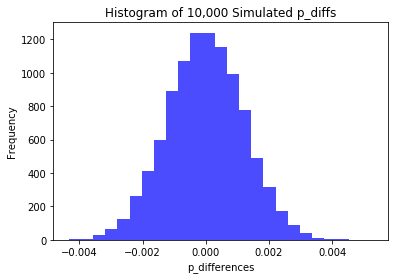

In [75]:
#Ploting p_diffs array
plt.hist(p_diffs, color = 'blue', alpha = 0.7, bins=25);
plt.xlabel('p_differences')
plt.ylabel('Frequency')
plt.title("Histogram of 10,000 Simulated p_diffs");

It looks like normal distribution.
Yes, I was expecting it to be a normal distribution.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

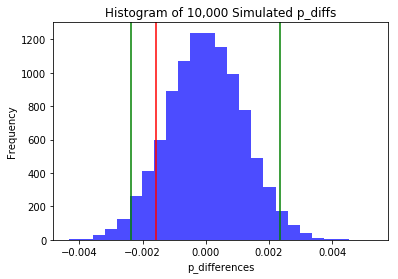

In [76]:
# calculated observed diffrence and showing it on histogram
observed_diff = (p_converted_treatment) - (p_converted_control)

# Checking what i calculted
#observed_diff

plt.hist(p_diffs, color = 'blue', alpha = 0.7, bins=25);
plt.xlabel('p_differences')
plt.ylabel('Frequency')
plt.title("Histogram of 10,000 Simulated p_diffs");
plt.axvline(observed_diff, color='red');

#Type I error rate of 5%
# plotting lines for confidence interval
low = np.percentile(p_diffs,2.5)
high = np.percentile(p_diffs, 97.5)
plt.axvline(low, color='green')
plt.axvline(high, color='green');


In [77]:
#Calculating p-value
p_diffs = np.array(p_diffs)
p_value = (p_diffs > observed_diff).mean()
p_value

0.90190000000000003

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer k.**

In part j, I calculated p-value, which is the probability that we will observe this statistic, given the Null Hypotheses is true. 

It looks like I have enough evidence to say that our statistic did come from this distribution. p-value is inside the confidence interval. A big enough p-value indicates that our statistic did come from this distribution.

A large enough p-value means we fail to reject the null-hypothesis, **$H_{o}$**: **$p_{new}$** - **$p_{old}$** <= 0

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [78]:
import statsmodels.api as sm

#import statsmodels.stats.proportion as sm

convert_old = df2.query('landing_page == "old_page" & converted == 1').shape[0]
convert_new = df2.query('landing_page == "new_page" & converted == 1').shape[0]

n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

convert_old,convert_new,n_old,n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [79]:
# given link is not working, I am using this link for help
# https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html

z_score, p_value = sm.stats.proportions_ztest(([convert_new,convert_old]),([n_new,n_old]), alternative = 'larger')
z_score, p_value


(-1.3109241984234394, 0.90505831275902449)

In [80]:
# Testing the Z-score

# How siginficant z-score is: remember alpha=0.05
# Critical value at 95% confidence interval

from scipy.stats import norm
norm.cdf(z_score) , norm.ppf(1-(0.05/2))



(0.094941687240975514, 1.959963984540054)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer n.**
A z-score is the number of standard deviations from the mean a data point is. But more technically it’s a measure of how many standard deviations below or above the population mean a raw score(observation) is.

When the z-score is very large (or very small) and associated with a very small p-value, this indicates it is unlikely that the pattern observed is a theoretically random pattern represented by the null (strong evidence against the null). Since the standard deviation here is small but our p-value is quite large, it does not appear to be of interest.


The z-score is approximately -1.311 and the p-value is 0.905. So do not have enough evidence to reject the null hypothesis. I think there is no difference between the old and new pages. The conclusion is the same as the findings in parts j. and k. I reached to the same decision by different ways of computing p-value. Given the above definition, it would seem that the differences between the lines shown in the histogram above is -1.31 standard deviations. The p-value is roughly 19.0% which is the probability that this result is due to random chance, this is not enough evidence to reject the null hypothesis and thus we fail to do so.


<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer 1.**

I would suggest logistic regression as each row can have one of binary values for converted column.I want to predict one of two values either user will convert or not convert based on page he receives.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [81]:
# Adding intercept column, disecting "group" column into two columns with get_dummies

df2['intercept'] = 1
df2[['extra_col', 'ab_page']] = pd.get_dummies(df2['group'])

# Checking how it went
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,extra_col,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [82]:
# Using statsmodels for logit
# copied it from : (Summery was not running)
# https://github.com/statsmodels/statsmodels/issues/3931
#from scipy import stats
#stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
# now summery is running without it. I dont get it.

# From knowledge questions at udacity i found that summery2 should be used.

# Setting up logistic regression
logit = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

# fitting results
result=logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [83]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-04-28 18:34 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Answer e.**

The p-value associated with ab_page is 19%  and since it is larger than our Type 1 error rate of 5%, 
I shows us that the landing page is not statistically significant in predicting whether the user will convert or not.

**Part-II Hypothseses:** (Aims to predict which page gets more conversions.)

**$H_{o}$**: **$p_{new}$** - **$p_{old}$** <= 0

**$H_{1}$**: **$p_{new}$** - **$p_{old}$** > 0



**Part-III Hypotheses:** (Only predicts  a difference  in  the two values.)

**$H_{o}$**: **$p_{old}$** = **$p_{new}$**

**$H_{1}$**: **$p_{old}$** != **$p_{new}$**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer f.**

One disadvantage of adding additional terms into a regression model can be collinearity. 

Explanatory variable can have association with each other that can make our results for response variable unreliable. VIF (variance inflation factors) can be used to remove the least important variables) if they are strogly colinear. To be honest I dont understand it fully.

Higher order explanatory variables which are not linearly related can appear (such as interactions, quadratics, and cubics) which are hard to explain/predict response variables. For example, if the slopes of two x variables are not parallel, this indicates that an interaction between those two variables is likely present. In this case, we can create a new column that multiplies these two values and review this added interaction with the predictor (y) variable.

Change aversion: gives unfair advantage to control group/ old page; users might be unhappy with change.

Novelty effect: gives unfair advantage to treatment group/ new page; users might be drawn to change.


g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [84]:
# Reading contries csv

countries_df = pd.read_csv('./countries.csv')

#Joining it with df2 and saving it in df_new
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [85]:
#extra cell to see new df
df_new.head()
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [86]:
# Create the necessary dummy variables, list new cols in alpha order
# Kept all 3 dummies in the df to check for accuracy, will drop from after
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()


,country,timestamp,group,landing_page,converted,intercept,extra_col,ab_page,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0


In [87]:
 # droping US (now baseline)
logit_2 = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'UK']])
result_2 = logit_2.fit()
result_2.summary2()


Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-04-28 18:34 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
CA           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
UK            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

In [88]:
# Since we are using logistic regression, will exponentiate it
1/np.exp(-0.0408), np.exp(0.0099)

(1.0416437559600236, 1.0099491671175422)

Compared to US(Baseline) overall conversions:

CA is 1.0416 times LESS likely to convert.

UK is 1.009 times MORE likely to convert.

With p-values (0.1291,0.4558) that are much greater than our Type 1 error rate of 0.05, it does not appear that
country has a significant impact on conversion.


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [89]:
#Creating two new columns to store intractions between country and page
df_new['CA_ab_page'] = df_new['CA'] * df_new['ab_page']
df_new['UK_ab_page'] = df_new['UK'] * df_new['ab_page']

# Instead of dropping I am not creating US column. US is basline
#df_new['US_ab_page'] = df_new['US'] * df_new['ab_page']

df_new.head()

,country,timestamp,group,landing_page,converted,intercept,extra_col,ab_page,CA,UK,US,CA_ab_page,UK_ab_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0,0,1


In [90]:
#after intraction
### Fit Your Linear Model And Obtain the Results
logit_3 = sm.Logit(df_new['converted'], df_new[['intercept', 'CA_ab_page', 'UK_ab_page']])
result_3 = logit_3.fit()
result_3.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-04-28 18:34 AIC:              212779.0384
No. Observations:   290584           BIC:              212810.7773
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9963    0.0062  -322.0487  0.0000  -2.0084  -1.9841
CA_ab_page   -0.0752    0.0376    -1.9974  0.0458  -0.1489  -0.0014
UK_ab_page    0.0149    0.0173     0.8617  0.3888  -0.0190   0.0488
==================================================================

"""

In [91]:
#Exponentiating to explain
# np.exp(result_3.params)
# minus sign is hard to explain so i will go with reciprocal for ease.

1/np.exp(-0.0752), np.exp(0.0149)

(1.0780997492739288, 1.0150115583846535)

For the treatment group (users who received the new page) and compared to Baseline US conversions:

CA is 1.078 times LESS likely to convert.

UK is 1.015 times MORE likely to convert.

With p-value of 0.0458 for CA_ab_page,our Type 1 error rate of 0.05, One can infer that CA has no significant impact on conversion.

But for UK, p-vaue (0.3888) that is much greater than our Type 1 error rate of 0.05, it does not appear that
UK has a significant impact on conversion.


<a id='conclusions'></a>
## Conclusion
In this project, our goal was to find out if the landing page has a significant impact on the propotion of converion. At the end of project we added if country of user impacts this propotion siginificantly.

Hence our null hypothesis was that the old landing page has the same or even higher converted rate than the new page, and our alternative hypothesis was that the old landing page has lower converted rate than the new page.

In order to get the result, we performed an A/B test by using two different methods: similating from the Null and calculating the Z-score. Both methods led to the same conclusion of retaining the null hypothesis, that is, landing page do not have sigificant effect on the conversion rate.

We also tried the regression approach by fitting a logistic regression model. Although the p-values are  different from what we got in the A/B test due to different null and alternative hypotheses, the result provided by the regression model agreed with the results in the A/B test.

It does appear that an interaction between country and page (holding all other variables constant) has an impact on the conversion rate because all of the p-values are not larger than 0.05 with this intraction.

Compared to the US, CA conversions overall and for the new page is lower, and in the UK overall and new page
conversions is higher. Perhaps CA has more change aversion and the UK users are more toeards to change (Novelty effect) , but these observed differences are quite small.

The test conditions were fairly good as, users had a roughly 50% chance to recieve the new and old pages and the sample size of the initial dataframe is sufficiently big such that collecting data is likely not a good use of resources.Duration of experiment was continous 22 days which is quite reasonable.Our Alpha is 5% for this experiment and confidense interval 95%.

My final thought would be to stick to the old page, belive in null hypothsis.



## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [93]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0